# 선형회귀(Numpy)

> 선형 회귀는 독립 변수(x)와 종속 변수(y) 간의 선형 관계를 모델링해서 "예측"하는 통계 기법입니다

## 모델

- 단순 모델: y = ax + b
- 다중 모델: y = a1x1 + a2x2 + ... + anxn + b

## 머신러닝 활용

 - y와 x가 결정 => {a,b} 매개변수를 찾아야 함
 - y와 x가 선형 관계를 가져야 함, 이상치와 다중공선성

 ## {a,b} 매개변수를 찾아야 함!
 
 - 매개변수를 찾는 방법: 최소제곱법, 경사하강법
 - 평가는 : MSE, R^2

## Numpy를 활용한 선형회귀 모델(v2)

> pip install scikit-learn 설치하세요

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target
# iris_df.head()

In [41]:
# 여기서 그래프를 보고 전처리를 해야함
# sns.pairplot(iris_df, hue="target")
# plt.suptitle("Iris Data Pair Plot")
# plt.show()

### 학습용 데이터(X, y)로 데이터 조작

In [42]:
X = np.column_stack([iris.data[:, 0], 
                     iris.data[:, 2], 
                     iris.data[:, 3]])
y = iris.data[:, 1]
#print(X.shape, y.shape)

In [43]:
# 학습용/검증용으로 데이터 나누기
def custom_train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    
    indices = np.random.permutation(len(X))
    split_idx = int(len(X) * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = custom_train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 3) (45, 3) (105,) (45,)


In [45]:
## 최소 제곱법
def fit_linear_regreesion_lsq(X, y):
    X_bias = np.column_stack([np.ones(len(X)), X]) # 매개변수 순서 중요!
    cofficients, _, _, _ = np.linalg.lstsq(X_bias, y)
    intercept_ = cofficients[0]
    coef_ = cofficients[1:]
    return coef_, intercept_

In [46]:
## 경사 하강법
#경사하강법의 성능과 동작방식을 결정하는 것은 *하이퍼 파라미터
#하이퍼 파라미터 : 모델이 학습을 통해 스스로 찾는 값(파라미터, 예: 가중치 w)이 아니라, 개발자가 직접 설정해줘야 하는 값
#경사하강법은 이상치에 민감 -> 이상치를 누르기 위해 정규화부터 해야함

def fit_linear_regreesion_gd(X, y, learning_rate=0.01, max_iter = 1000, tolerance = 1e-6):
    """
    learning_rate(학습률) : 기울기를 얼마만큼 이동 시킬지 결정
    max_iter(최대이동 횟수) : 기울기를 최대 몇번 이동 시킬지 결정
    tolerance(수렴조건) : max_iter번 시행하는 중에 tolerance를 만족하면 멈춤
    """
    n_samples, n_features = X.shape

    weights = np.random.normal(0, 0.01, n_features+1) #정규화(MSE를 이용해서 비용함수를 계산할 것이라서 이상치에 민감-> 이상치를 누르기 위해 정규화 필요함) #절편도 가져옴
    X_with_bias = np.column_stack([np.ones(n_samples),X]) # [절편, 특징1, 특징2, 특징 3]..이 총 150개  # 매개변수의 순서조심 -> 절편이 맨 앞으로 나옴
    
    cost_history= []

    for i in range(max_iter):
        #1. 예측값 계산
        predictions = X_with_bias @ weights # 정규화된 값을 초기값으로 넣게 되면, 그냥 랜덤한 값을 넣는 것보다는 유의미할 것

        #2. 비용함수를 계산 -> MSE 이용
        cost = np.mean((predictions-y)**2)
        cost_history.append(cost)

        #3. 기울기 계산 -> 편미분 공식을 이용하기 (aj/aw) = (2/n)*(X^T)*(Xw-y)
        gradients = (2/n_samples) * X_with_bias.T @ (predictions-y)

        #4. 가중치를 업데이트
        weights = weights - learning_rate*gradients # 이 과정을 통해서 최적해 기울기를 구할 수 있음

        #5. 수렴조건 점검
        if i>0 and abs(cost_history[-2] - cost_history[-1])<tolerance:
            print(f"경사하강법이 {i+1}번째 이동에서 수렴했음")
            break

    intercept_ = weights[0] 
    coef_ = weights[1:]

    return coef_, intercept_, cost_history

In [47]:
def predict_linear_regreesion(X, coef_, intercept_):
    return X @ coef_ + intercept_

In [48]:
coef_, intercept_ = fit_linear_regreesion_lsq(X_train, y_train)
y_pred_lsq = predict_linear_regreesion(X_test, coef_, intercept_)

In [49]:
coef_, intercept_, _= fit_linear_regreesion_gd(X_train, y_train)
y_pred_gd = predict_linear_regreesion(X_test, coef_, intercept_)

### 회귀모델 성능평가 지표 ex) MAE, MSE, RMSE .... 많음

In [50]:
# MSE(평균제곱오차) : 실제값, 예측값을 매개변수로 받아와야함
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

In [51]:
# R^2(결정계수) : 
def r2_score(y_true, y_pred):
    # 잔차의 제곱합 = 오차의 제곱합과 동일하게 구함
    ss_res = np.sum((y_true-y_pred)**2)

    # 총 제곱합
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true-y_mean)**2)

    #r2
    r2 = 1-(ss_res/ss_tot)
    return r2

In [52]:
mse_lsq = mean_squared_error(y_test, y_pred_lsq)
r2_lsq = r2_score(y_test, y_pred_lsq)
print(mse_lsq, r2_lsq)

0.0847219715794219 0.3810001715675807


In [53]:
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print(mse_gd, r2_gd)

0.10692359591372268 0.21878957380109543


### 성능 어떻게 높이지?

In [54]:
def std_feat(X_train, X_test): # 평균 0, 표준편차 1
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_scaled = (X_train-mean)/std
    X_test_scaled = (X_test-mean)/std

    return X_train_scaled, X_test_scaled

In [55]:
X_train_scaled, X_test_scaled = std_feat(X_train, X_test)

In [56]:
coef_, intercept_, _ = fit_linear_regreesion_gd(X_train_scaled, y_train)
y_pred_gd = predict_linear_regreesion(X_test_scaled, coef_, intercept_)

In [57]:
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print(mse_gd, r2_gd)

0.09576411976970939 0.3003234863123774


### Learning rate(학습률)에 따른 학습결과

경사하강법이 509번째 이동에서 수렴했음


c:\Users\user\miniconda3\envs\aip\lib\site-packages\numpy\_core\_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\user\AppData\Local\Temp\ipykernel_14140\890711577.py:34: RuntimeWarning: invalid value encountered in scalar subtract
  if i>0 and abs(cost_history[-2] - cost_history[-1])<tolerance:
C:\Users\user\AppData\Local\Temp\ipykernel_14140\890711577.py:24: RuntimeWarning: overflow encountered in square
  cost = np.mean((predictions-y)**2)


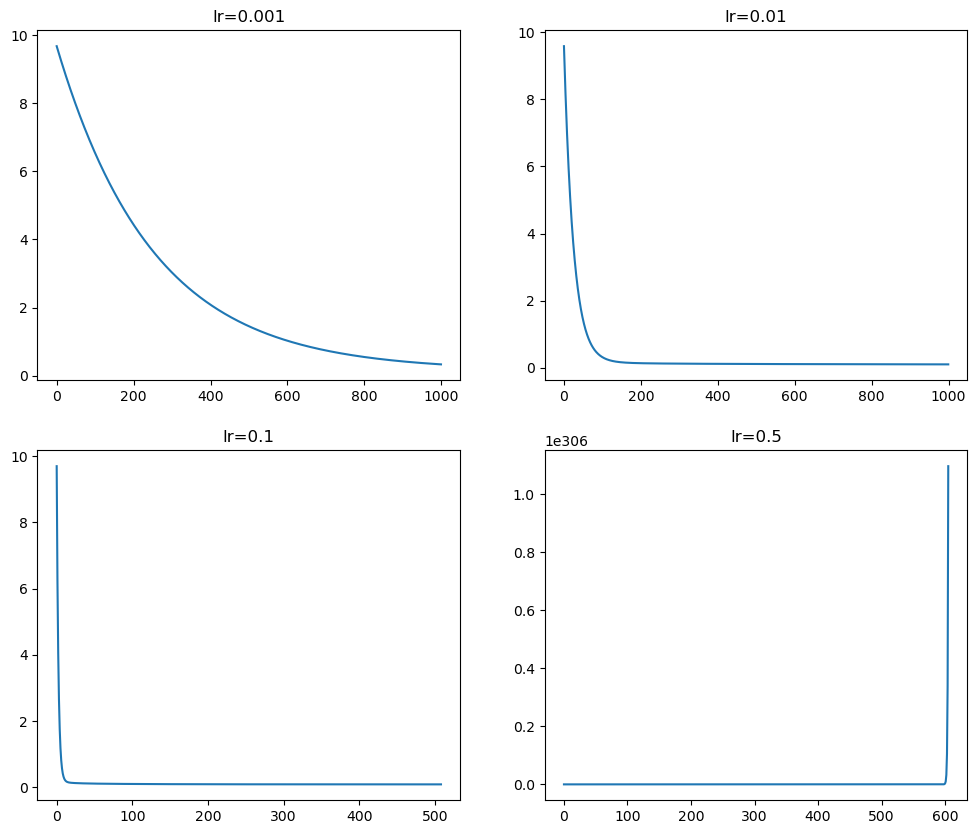

In [62]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
figs, axes = plt.subplots(2,2, figsize=(12, 10))
axes = axes.ravel()

for i, lr in enumerate(learning_rates):
    _,_,cost_history = fit_linear_regreesion_gd(X_train_scaled, y_train, learning_rate=lr)

    axes[i].plot(cost_history)
    axes[i].set_title(f"lr={lr}")